In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
data = pd.read_csv("./data/diabetes.csv")
df = data.copy()

In [3]:
def check_df(dataframe: object, head: object = 5) -> object:
    print("########################### Shape ###########################")
    print(dataframe.shape)

    print("########################### Types ###########################")
    print(dataframe.dtypes)

    print("########################### Head ###########################")
    print(dataframe.head(head))

    print("########################### Tail ###########################")
    print(dataframe.tail(head))

    print("########################### NA ###########################")
    print(dataframe.isnull().sum())

    print("########################### Quantiles ###########################")
    print(dataframe.quantile([0, 0.05,0.1, 0.25, 0.50,0.75, 0.90, 0.95, 0.99, 1]).T)

In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


   Outcome  Ratio
0      500 65.104
1      268 34.896


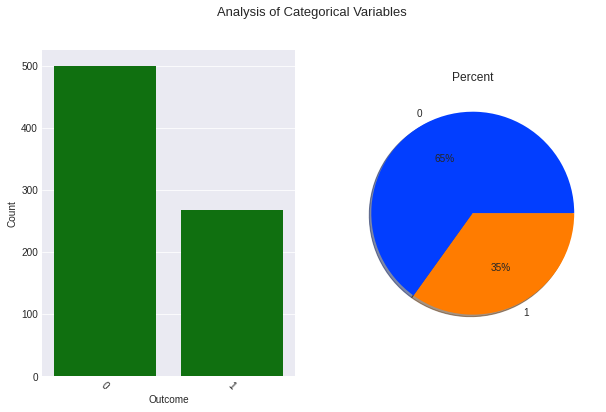

In [5]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        plt.style.use('seaborn-darkgrid')
        fig, ax = plt.subplots(1, 2)
        ax = np.reshape(ax, (1, 2))
        ax[0, 0] = sns.countplot(x=dataframe[col_name], color="green", ax=ax[0, 0])
        ax[0, 0].set_ylabel('Count')
        ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=-45)
        ax[0, 1] = plt.pie(dataframe[col_name].value_counts().values, labels=dataframe[col_name].value_counts().keys(),
                           colors=sns.color_palette('bright'), shadow=True, autopct='%.0f%%')
        plt.title("Percent")
        fig.set_size_inches(10, 6)
        fig.suptitle('Analysis of Categorical Variables', fontsize=13)
        plt.show()


for col in cat_cols:
    cat_summary(df, col, plot=True)

## Analysis of Numerical Variables

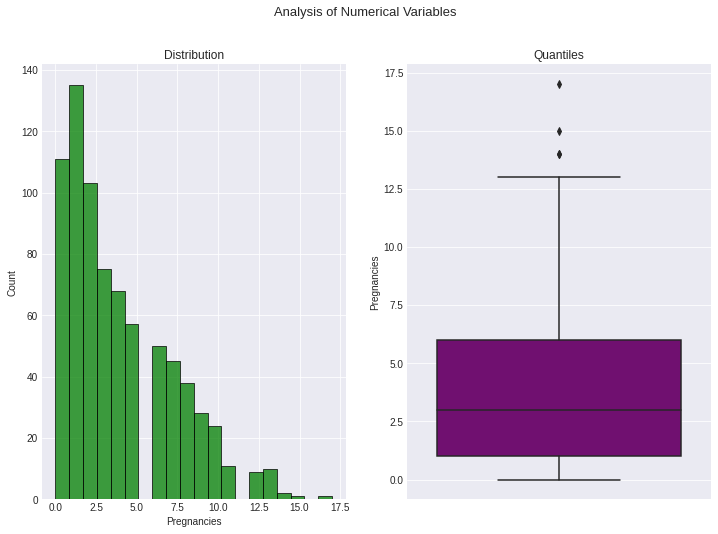

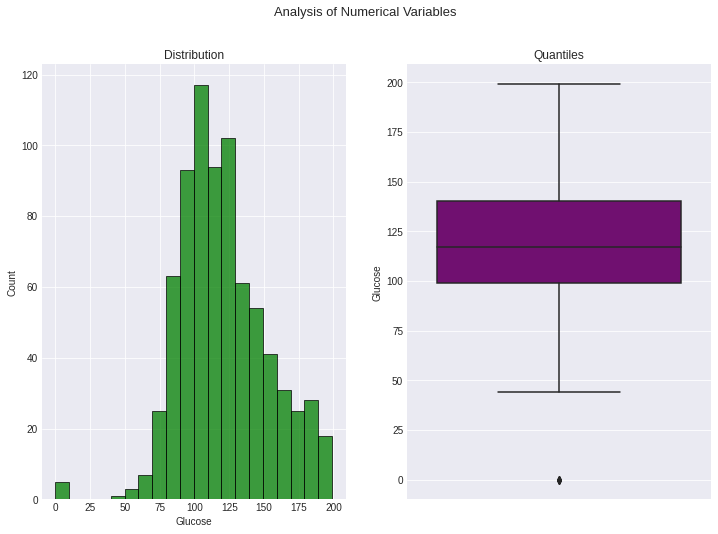

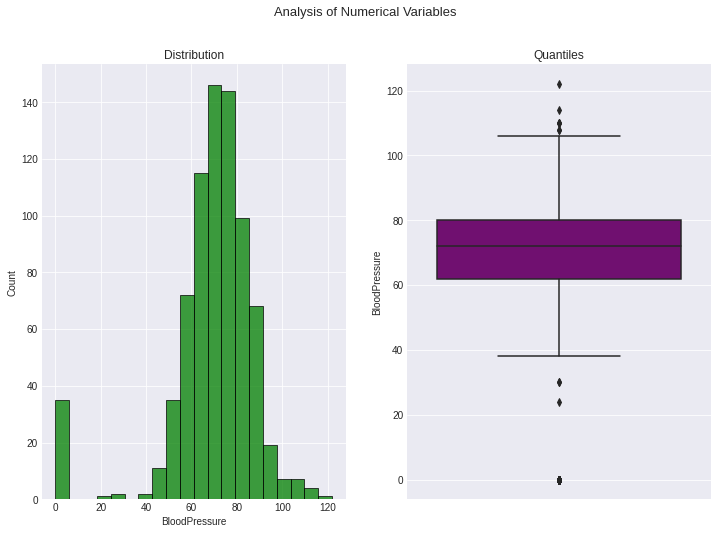

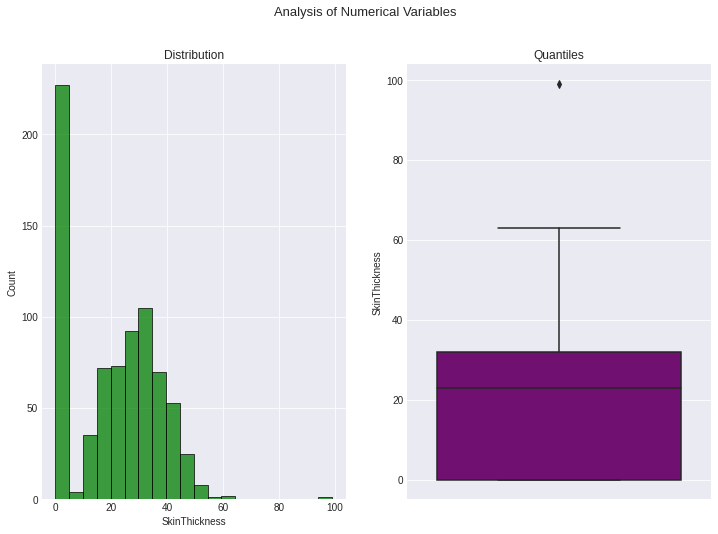

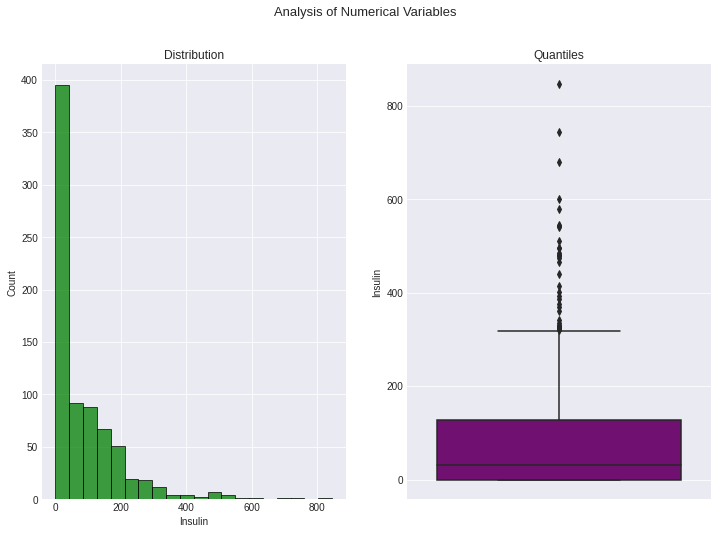

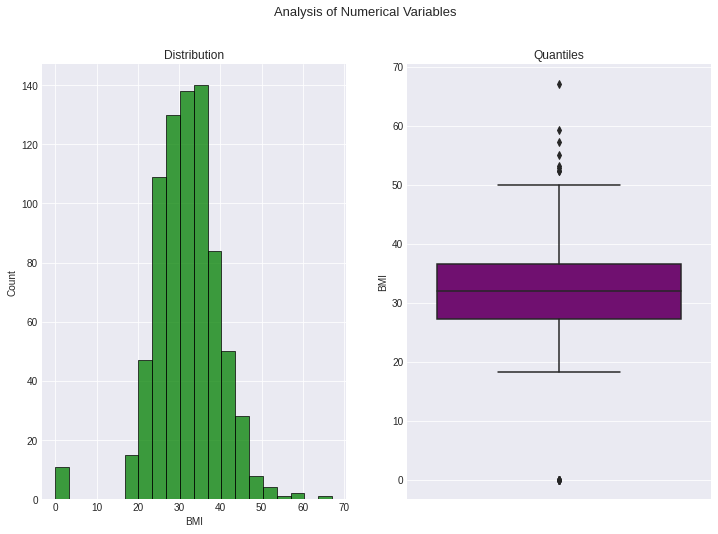

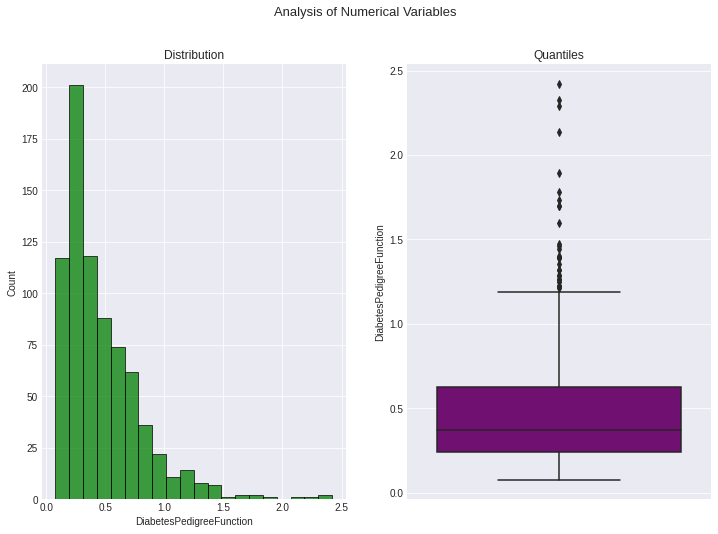

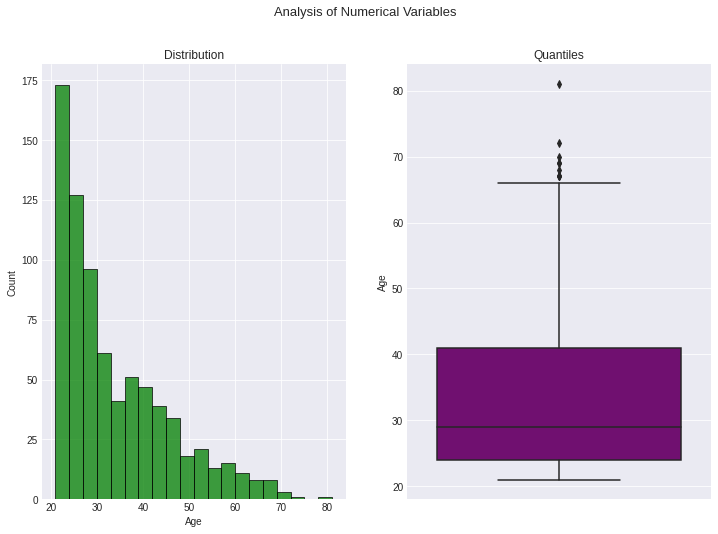

In [6]:
def num_summary(dataframe, numerical_col):
    # setup the plot grid
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(1, 2)
    ax = np.reshape(ax, (1, 2))
    ax[0, 0] = sns.histplot(x=dataframe[numerical_col], color="green", bins=20, ax=ax[0, 0])
    ax[0, 0].set_ylabel('Count')
    ax[0, 0].set_title('Distribution')
    ax[0, 1] = sns.boxplot(y=dataframe[numerical_col], color="purple", ax=ax[0, 1])
    ax[0, 1].set_title('Quantiles')

    fig.set_size_inches(12, 8)
    fig.suptitle('Analysis of Numerical Variables', fontsize=13)
    plt.show()

for col in df[num_cols]:
    num_summary(df, col)

## Analysis of Correlation

<a id = "6"></a><h1 id="Data Preprocessing"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; color: Black; ">Data Preprocessing</span></h1>

## Missing Values

In [7]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
    
missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

## Outliers

In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in num_cols:
    print(outlier_thresholds(df, col))

(-15.0, 25.0)
(-74.0, 334.0)
(-38.249999999999986, 166.95)
(-66.0, 110.0)
(-439.5, 732.5)
(-12.09249999999999, 78.2875)
(-1.3483999999999996, 2.621599999999999)
(-34.5, 113.5)


In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df,col)

## Label Encoding

In [10]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
len(binary_cols)

0

In [11]:
for col in binary_cols:
    label_encoder(df, col)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1
1,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000,0
2,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1


## One-Hot Encoding

In [12]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols, drop_first=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1
1,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000,0
2,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1


In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


## Standart Scaler

In [14]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

#check_df(df)

In [15]:
from enhance_data import enhance_data

In [16]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
log_model = LogisticRegression().fit(X_train, y_train)


fitting new wasserstein generator on smaller data
Epoch   1 | ET 0.01 min | Avg Losses >> G/D   0.07/355.81 [D-Real:   0.04 D-Fake:  -0.07]
Epoch   2 | ET 0.02 min | Avg Losses >> G/D   0.10/206.79 [D-Real:   0.02 D-Fake:  -0.10]
Epoch   3 | ET 0.02 min | Avg Losses >> G/D   0.06/117.31 [D-Real:   0.10 D-Fake:  -0.06]
Epoch   4 | ET 0.03 min | Avg Losses >> G/D   0.09/ 67.88 [D-Real:   0.12 D-Fake:  -0.09]
Epoch   5 | ET 0.04 min | Avg Losses >> G/D   0.10/ 39.19 [D-Real:   0.08 D-Fake:  -0.10]
Epoch   6 | ET 0.05 min | Avg Losses >> G/D   0.07/ 25.05 [D-Real:   0.06 D-Fake:  -0.07]
Epoch   7 | ET 0.06 min | Avg Losses >> G/D   0.09/ 16.39 [D-Real:   0.07 D-Fake:  -0.09]
Epoch   8 | ET 0.07 min | Avg Losses >> G/D   0.09/ 12.49 [D-Real:   0.14 D-Fake:  -0.09]
Epoch   9 | ET 0.08 min | Avg Losses >> G/D   0.10/ 10.72 [D-Real:   0.10 D-Fake:  -0.10]
Epoch  10 | ET 0.08 min | Avg Losses >> G/D   0.05/  9.52 [D-Real:   0.05 D-Fake:  -0.05]
Epoch  11 | ET 0.09 min | Avg Losses >> G/D   0.1

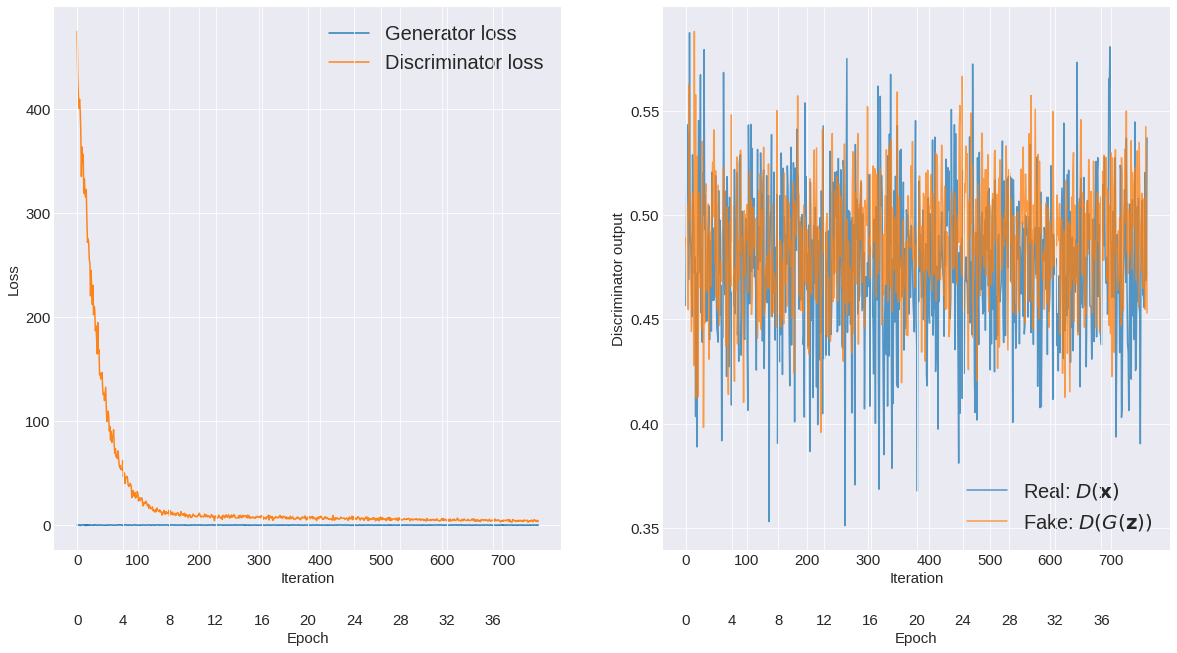

In [19]:
enh = enhance_data(x_train=X_train, y_train=y_train, force_generator=True, synthetic_share=.2, wasserstein=True)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [21]:
log = pd.DataFrame(columns=["model", "accuracy", "enhanced_data"])
log['enhanced_data'] = log['enhanced_data'].astype(bool)

## logreg

In [22]:
clf = LogisticRegression(solver='liblinear')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_train, y_train)

score = accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

array([[79, 20],
       [18, 37]])

In [23]:
log = log.append({"model": "logistic regression", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [24]:
clf = LogisticRegression(solver='liblinear')

clf.fit(enh['x_train_processed'], enh['y_train'])

y_pred = clf.predict(X_test)

clf.score(X_train, y_train)

score = accuracy_score(y_test, y_pred)

confusion_matrix(y_test, y_pred)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([[73, 26],
       [18, 37]])

In [25]:

log = log.append({"model": "logistic regression", "accuracy": score, "enhanced_data": True}, ignore_index=True)

## SVC

In [26]:
from sklearn.svm import SVC

In [27]:
model = SVC(kernel="rbf",C=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

In [28]:

log = log.append({"model": "SVC", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [29]:
model = SVC(kernel="rbf",C=1)

model.fit(enh['x_train_processed'], enh['y_train'])

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [30]:
log = log.append({"model": "SVC", "accuracy": score, "enhanced_data": True}, ignore_index=True)

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
clf = RandomForestClassifier(random_state = 1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "Random Forest", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [33]:

clf = RandomForestClassifier(random_state = 1)
clf.fit(enh['x_train_processed'], enh['y_train'])
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "Random Forest", "accuracy": score, "enhanced_data": True}, ignore_index=True)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## decision tree


In [34]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy',random_state=7)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "Decision tree", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [35]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy',random_state=7)
clf.fit(enh['x_train_processed'], enh['y_train'])
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "Decision tree", "accuracy": score, "enhanced_data": True}, ignore_index=True)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
clf.predict(X_test)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "K nearest neighbours", "accuracy": score, "enhanced_data": False}, ignore_index=True)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [38]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(enh['x_train_processed'], enh['y_train'])
clf.predict(X_test)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "K nearest neighbours", "accuracy": score, "enhanced_data": True}, ignore_index=True)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## naive bayes

In [39]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
clf.predict(X_test)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "GaussianNB", "accuracy": score, "enhanced_data": False}, ignore_index=True)

In [40]:

clf = GaussianNB()
clf.fit(enh['x_train_processed'], enh['y_train'])
clf.predict(X_test)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
log = log.append({"model": "GaussianNB", "accuracy": score, "enhanced_data": True}, ignore_index=True)

/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/home/paul/.local/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(



## NeuralNet

In [41]:
from tensorflow.keras import models, Model, layers
from tensorflow.keras.callbacks import EarlyStopping


model = models.Sequential()
model.add(layers.InputLayer(input_shape=X_train.shape[1:]))

for i in range(5):
        model.add(layers.Dense(
            64, 
            kernel_initializer='he_normal',
            name=f'hidden_layer_{i}'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('selu'))
        model.add(layers.Dropout(0.3, name=f'dropout_{i}_30'))
    
model.add(layers.Dense(1, activation='sigmoid'))

#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 64)                576       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_0_30 (Dropout)       (None, 64)                0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_6 (Activation)    (None, 64)               

In [42]:
history = model.fit(
    X_train, y_train, validation_split=.2, epochs=300,
    callbacks=[
        EarlyStopping(patience=20, monitor='val_accuracy', mode='max', restore_best_weights=True)])

Epoch 1/300
16/16 [==============================] - 2s 52ms/step - loss: 0.7292 - accuracy: 0.6232 - val_loss: 0.9404 - val_accuracy: 0.7236
Epoch 2/300
16/16 [==============================] - 0s 20ms/step - loss: 0.7066 - accuracy: 0.6558 - val_loss: 0.6888 - val_accuracy: 0.7317
Epoch 3/300
16/16 [==============================] - 1s 34ms/step - loss: 0.6571 - accuracy: 0.6578 - val_loss: 0.6201 - val_accuracy: 0.7398
Epoch 4/300
16/16 [==============================] - 0s 27ms/step - loss: 0.6332 - accuracy: 0.6986 - val_loss: 0.5943 - val_accuracy: 0.7317
Epoch 5/300
16/16 [==============================] - 0s 13ms/step - loss: 0.6384 - accuracy: 0.6762 - val_loss: 0.5513 - val_accuracy: 0.7480
Epoch 6/300
16/16 [==============================] - 0s 19ms/step - loss: 0.6139 - accuracy: 0.7047 - val_loss: 0.5259 - val_accuracy: 0.7561
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 0.5609 - accuracy: 0.7128 - val_loss: 0.5290 - val_accuracy: 0.7724
Epoch 

In [43]:
result = model.evaluate(X_test, y_test)
result[1]
log = log.append({"model": "DenseNeuralNet", "accuracy": result[1], "enhanced_data": False}, ignore_index=True)

5/5 [==============================] - 0s 15ms/step - loss: 0.5876 - accuracy: 0.7078


In [44]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=X_train.shape[1:]))

for i in range(5):
        model.add(layers.Dense(
            64, 
            kernel_initializer='he_normal',
            name=f'hidden_layer_{i}'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('selu'))
        model.add(layers.Dropout(0.3, name=f'dropout_{i}_30'))
    
model.add(layers.Dense(1, activation='sigmoid'))

#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [45]:
history = model.fit(
    enh['x_train_processed'], enh['y_train'], validation_split=.2, epochs=300,
    callbacks=[
        EarlyStopping(patience=20, monitor='val_accuracy', mode='max', restore_best_weights=True)])

Epoch 1/300
19/19 [==============================] - 5s 68ms/step - loss: 0.8340 - accuracy: 0.5731 - val_loss: 0.6426 - val_accuracy: 0.7568
Epoch 2/300
19/19 [==============================] - 1s 32ms/step - loss: 0.6919 - accuracy: 0.6361 - val_loss: 0.7116 - val_accuracy: 0.7703
Epoch 3/300
19/19 [==============================] - 0s 17ms/step - loss: 0.6221 - accuracy: 0.7058 - val_loss: 0.6371 - val_accuracy: 0.7703
Epoch 4/300
19/19 [==============================] - 1s 31ms/step - loss: 0.5836 - accuracy: 0.7279 - val_loss: 0.5769 - val_accuracy: 0.7770
Epoch 5/300
19/19 [==============================] - 1s 52ms/step - loss: 0.6328 - accuracy: 0.6820 - val_loss: 0.5213 - val_accuracy: 0.7770
Epoch 6/300
19/19 [==============================] - 1s 27ms/step - loss: 0.5695 - accuracy: 0.7245 - val_loss: 0.5321 - val_accuracy: 0.7770
Epoch 7/300
19/19 [==============================] - 0s 23ms/step - loss: 0.6064 - accuracy: 0.7075 - val_loss: 0.5213 - val_accuracy: 0.7905
Epoch 

In [46]:
result = model.evaluate(X_test, y_test)
result[1]

5/5 [==============================] - 0s 10ms/step - loss: 0.6387 - accuracy: 0.6883


0.6883116960525513

In [47]:
log = log.append({"model": "DenseNeuralNet", "accuracy": result[1], "enhanced_data": True}, ignore_index=True)

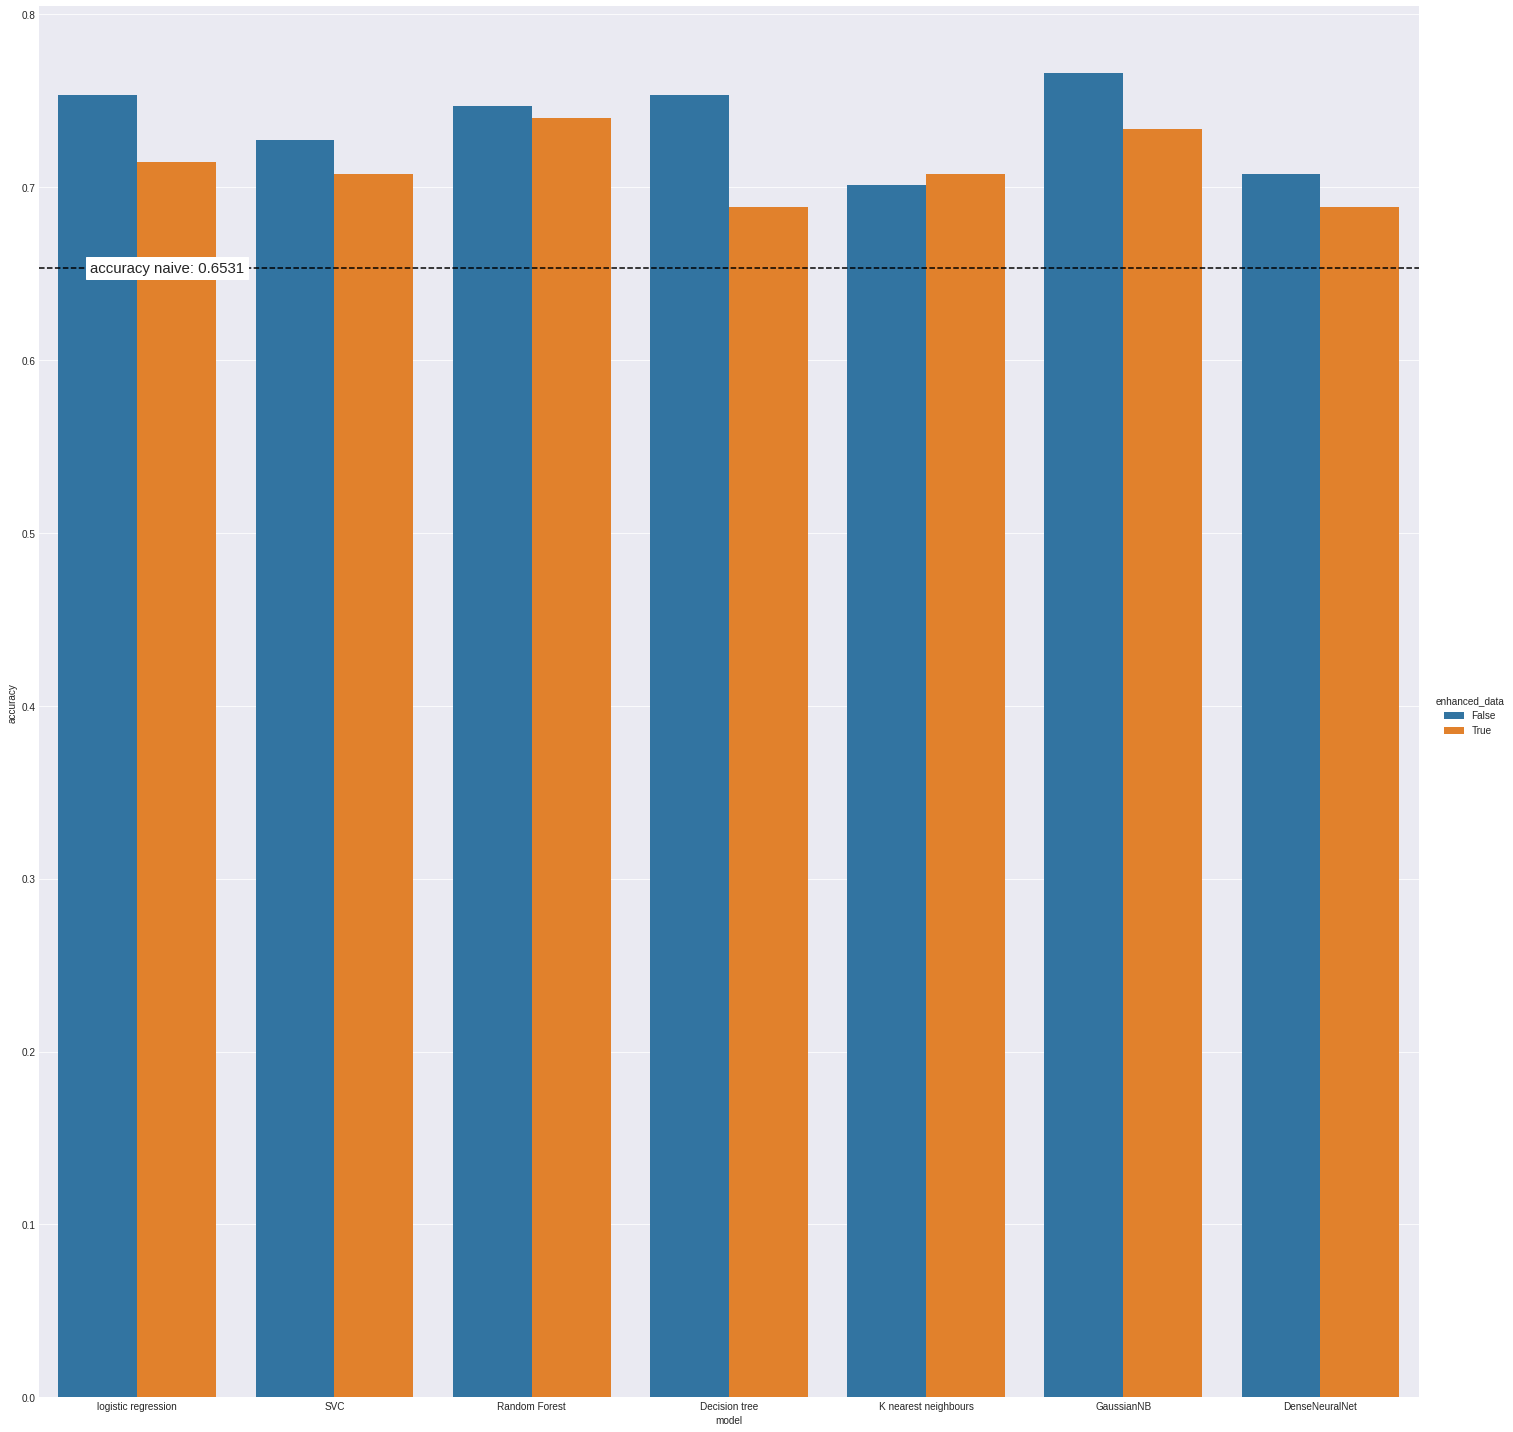

In [48]:
import seaborn as sns
from matplotlib import pyplot as plt


c = sns.catplot(
    data=log,
    x='model',
    y='accuracy',
    hue='enhanced_data',
    kind='bar',
    height=20
)

naive_baseline = 1 - y_train.mean()

axes = c.axes.flatten()
for i, ax in enumerate(axes):
    accuracy = naive_baseline
    
    ax.axhline(accuracy, ls='--', c='black')
    ax.text(0.15, accuracy, 
            f'accuracy naive: {round(accuracy, 4)}', 
            fontsize=15, va='center', ha='center', backgroundcolor='w')


plt.savefig('./diabetes_boosting_experiments.jpg')